In [32]:
# deep dive on ABC-SMC
# generations 
# projections
# calibration with external models

# Calibration of Epidemic Models to Data with Epydemix - Part 2

In this second part of the tutorial, we will explore more advanced calibration features. Our primary focus will be on the ABC-SMC algorithm, as it is the most flexible and powerful method available. However, many of the concepts and techniques discussed can also be applied to other calibration algorithms.

Let's import the needed packages:

In [33]:
from scipy import stats 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from epydemix.model import EpiModel, simulate
from epydemix.visualization import plot_posterior_distribution
from epydemix.calibration import calibrate, rmse
from epydemix.utils import compute_simulation_dates, compute_quantiles

import seaborn as sns   
colors = sns.color_palette("Dark2")

Before starting we import data and define the model that we used in part 1 of the tutorial:

In [34]:
# data 
data = pd.read_csv('./data/data_I.csv')
data["date"] = pd.to_datetime(data["date"])

# model 
model = EpiModel(predefined_model='SIR')
model.import_epydemix_population(population_name="Indonesia")

# initial conditions (we assume fully S population except for 20,000 infected individual across age groups)
initial_conditions = {"Susceptible": model.population.Nk - np.ones(len(model.population.Nk)) * 4000, 
                      "Infected": np.ones(len(model.population.Nk)) * 4000,
                      "Recovered": np.zeros(len(model.population.Nk))}

# simulation dates 
simulation_dates = compute_simulation_dates(start_date=data.date.values[0], end_date=data.date.values[-1])

# simulation parameters
parameters = {"initial_conditions_dict": initial_conditions,
              "epimodel": model, 
              "simulation_dates": simulation_dates}

# priors
priors = {"transmission_rate": stats.uniform(0.015, 0.025), 
          "recovery_rate": stats.uniform(0.15, 0.25)}

# wrapper function
def simulate_wrapper(parameters): 
    results = simulate(**parameters)
    results.update({"data": results["Infected_total"]})
    return results

## 1. ABC-SMC Perturbation Kernels

An important aspect of the ABC-SMC algorithm are pertubation kernels. Perturbation kernels in ABC-SMC are probability distributions used to introduce small random variations to parameter values during the iterative sampling process, allowing the algorithm to explore the parameter space more effectively while maintaining diversity in the population of particles.

By default, in Epydemix, continuous parameters use multivariate normal transition kernels, with the covariance matrix estimated from the previous generation of particles. Discrete parameters, on the other hand, utilize a discrete jump transition kernels.

Users can define their own custom perturbation kernels by implementing the abstract class `Perturbation`. Below, we provide a simple example where we create a perturbation kernel that modifies parameters by adding random noise sampled from a uniform distribution within a specified range:

In [4]:
from epydemix.utils import Perturbation

class ScaledPerturbation(Perturbation):
    def __init__(self, param_name, scale=0.1):
        super().__init__(param_name)
        self.scale = scale

    def propose(self, x):
        """Propose a new value by adding scaled noise (with positive constraint)."""
        return np.abs(x + np.random.uniform(-self.scale, self.scale))

    def pdf(self, x, center):
        """Evaluate the PDF of the kernel."""
        if abs(x - center) <= self.scale:
            return 1 / (2 * self.scale)  # Uniform density within the range
        return 0

    def update(self, particles, weights, param_names):
        """No updates needed for this simple kernel."""
        pass


This user-defined perturbation kernel can then be used in the ABC-SMC algorithm by specifying to which parameter must be applied:

In [5]:
results_abc_smc = calibrate(strategy="abc_smc", 
                    simulation_function=simulate_wrapper, 
                    priors=priors, 
                    parameters=parameters, 
                    observed_data={"data": data["data"].values}, 
                    num_particles=100, 
                    max_generations=5, 
                    distance_function=rmse, 
                    perturbations={
                        "transmission_rate": ScaledPerturbation("transmission_rate", scale=0.005)
                    })

Running generation 1, epsilon: 18309684.191217594
	Elapsed time: 00:00:07
Running generation 2, epsilon: 10482899.946829189
	Elapsed time: 00:00:06
Running generation 3, epsilon: 7306487.142634714
	Elapsed time: 00:00:09
Running generation 4, epsilon: 5650496.959221589
	Elapsed time: 00:00:12
Running generation 5, epsilon: 4718601.372432444
	Elapsed time: 00:00:18


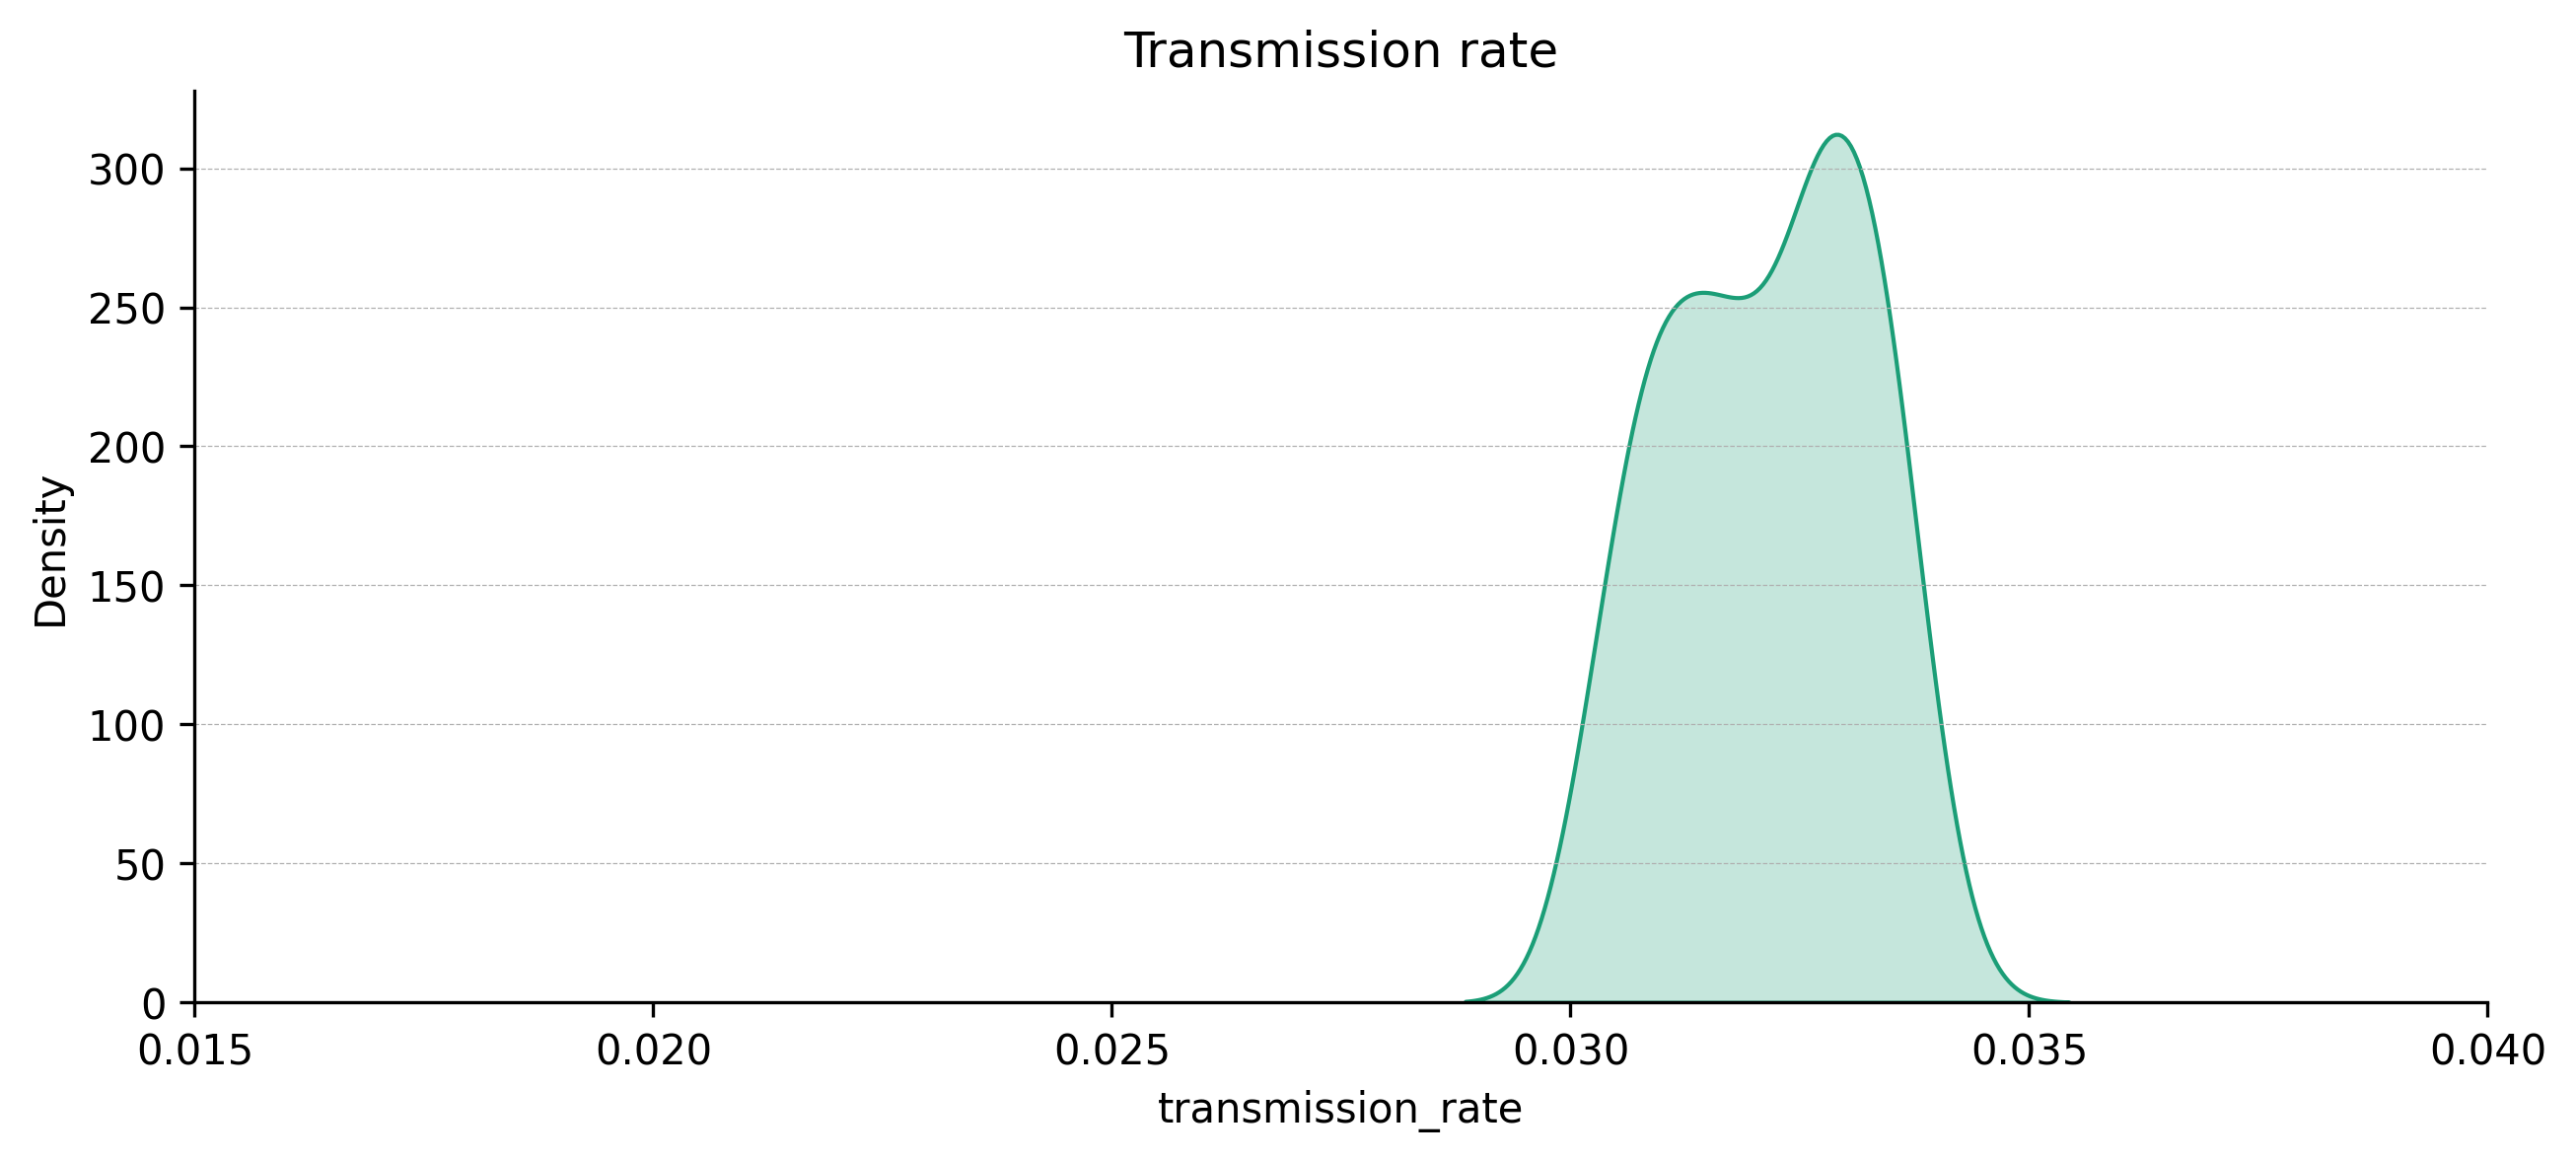

In [6]:
plot_posterior_distribution(results_abc_smc, "transmission_rate", kind="kde", title="Transmission rate", prior_range=True, color=colors[0], label="ABC-SMC")

We can also test the evolution of the posterior distributions in different generations: 

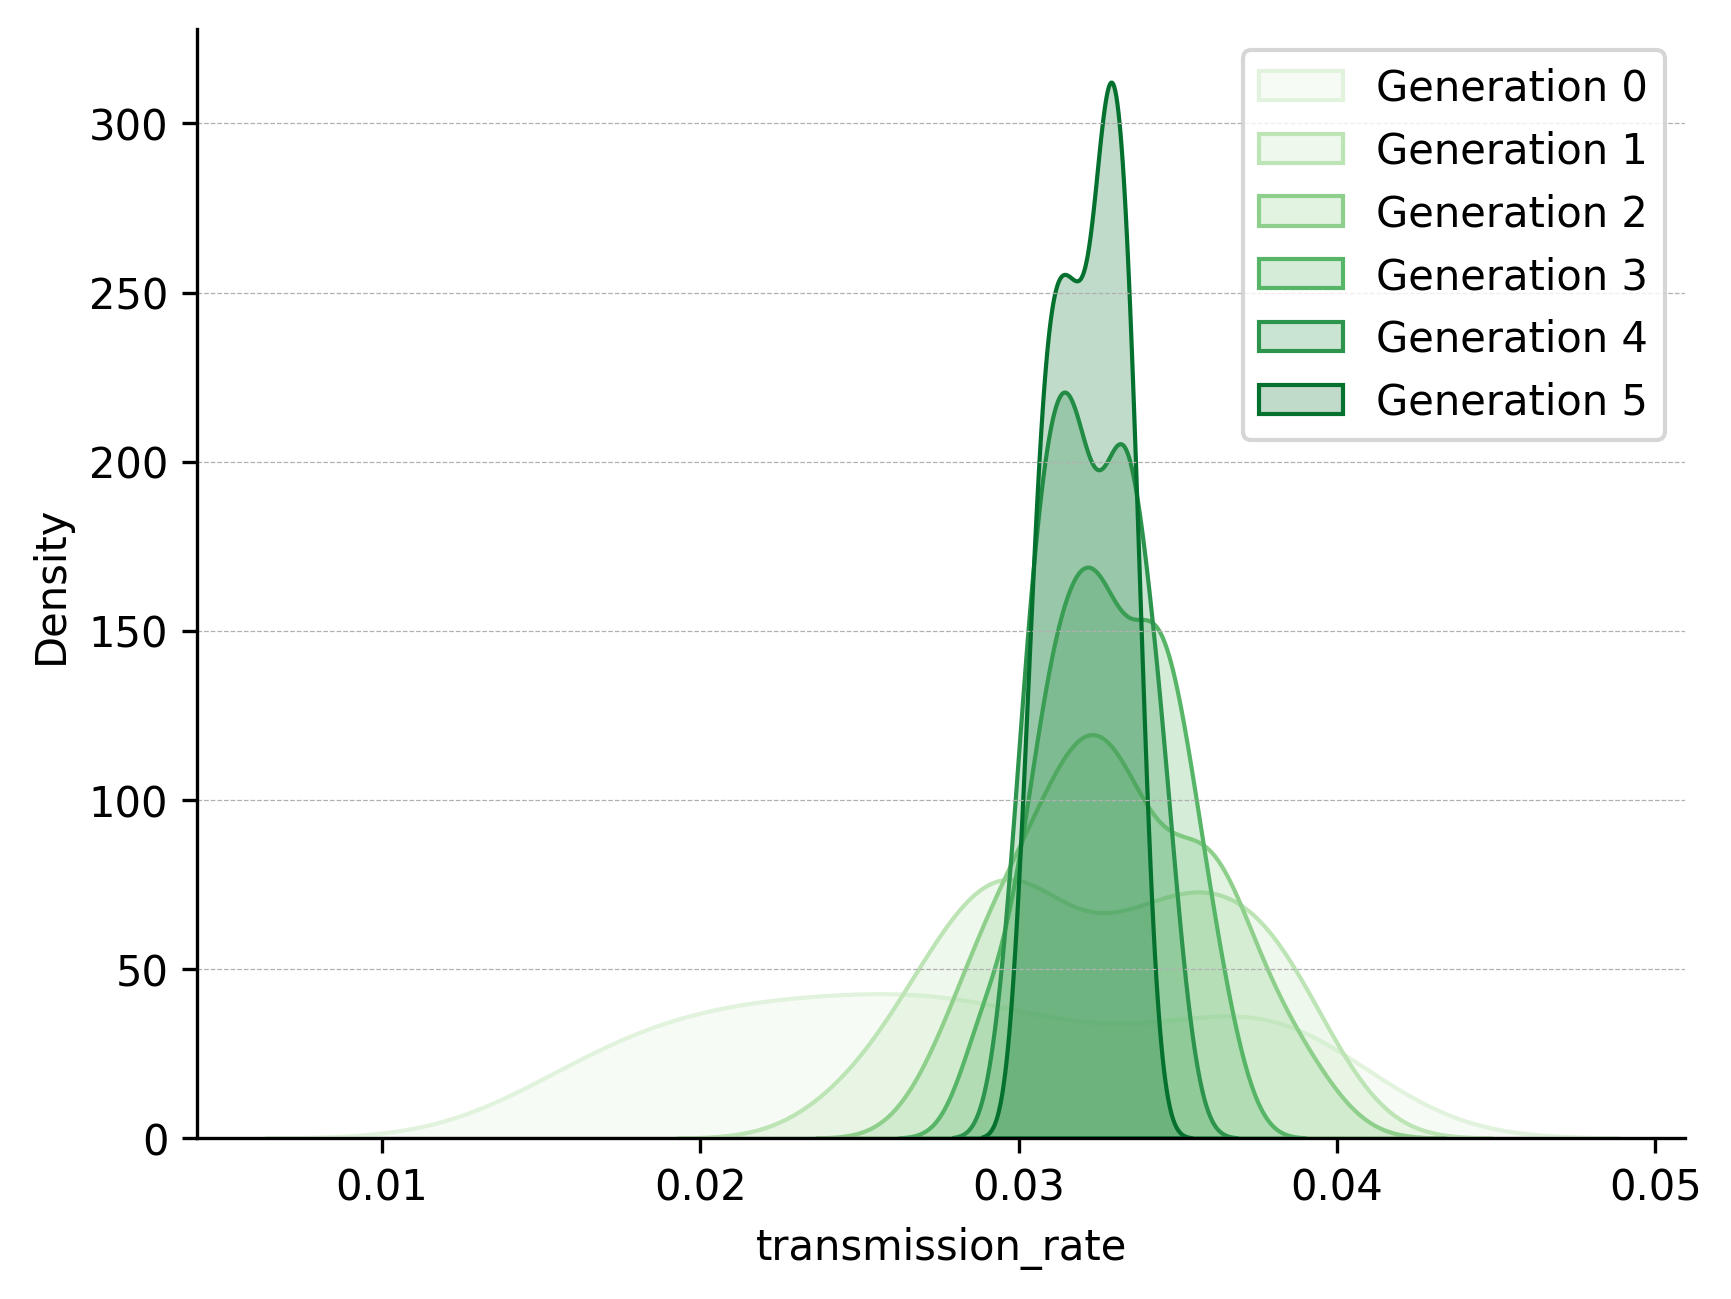

In [ ]:
fig, ax = plt.subplots(dpi=300)
for generation, color in zip(range(6), sns.color_palette("Greens", n_colors=6)): 
    plot_posterior_distribution(results_abc_smc, generation=generation, parameter="transmission_rate", ax=ax, kind="kde", prior_range=False, color=color, label="Generation %d" % generation)
ax.legend() 

## 2. Running Projections

After calibrating the models, it is often useful to run projections into the future to explore how the epidemic might evolve. In **Epydemix**, this can be achieved using the `run_projections` function.

In this tutorial, we will first perform the calibration over a shorter time frame to fit the model to the observed data. Once calibrated, we will use the `run_projections` function to project the epidemic's trajectory over the remaining period, providing insights into possible future outcomes.

In [41]:
from epydemix.calibration import run_projections

# exclude last 40 days from calibration
simulation_dates_calibration = compute_simulation_dates(start_date=data.date.values[0], end_date=data.date.values[-40])
parameters_calibration = parameters.copy() 
parameters_calibration["simulation_dates"] = simulation_dates_calibration

# calibrate the model
results_abc_smc = calibrate(strategy="abc_smc", 
                    simulation_function=simulate_wrapper, 
                    priors=priors, 
                    parameters=parameters_calibration,  ### Note here we use the calibration parameters (shorter time frame)
                    observed_data={"data": data["data"].values[:-39]}, 
                    num_particles=100, 
                    max_generations=5, 
                    distance_function=rmse)

# run projections
projections_trajectories, posterior_samples = run_projections(simulate_wrapper, 
                                                         results_abc_smc, 
                                                         parameters   ### Note here we use the parameters for the full time frame
                                                        )

Running generation 1, epsilon: 22749035.26313305
	Elapsed time: 00:00:05
Running generation 2, epsilon: 14194996.547315383
	Elapsed time: 00:00:06
Running generation 3, epsilon: 9643720.544380344
	Elapsed time: 00:00:06
Running generation 4, epsilon: 6471374.034958318
	Elapsed time: 00:00:07
Running generation 5, epsilon: 5022385.198181287
	Elapsed time: 00:00:07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


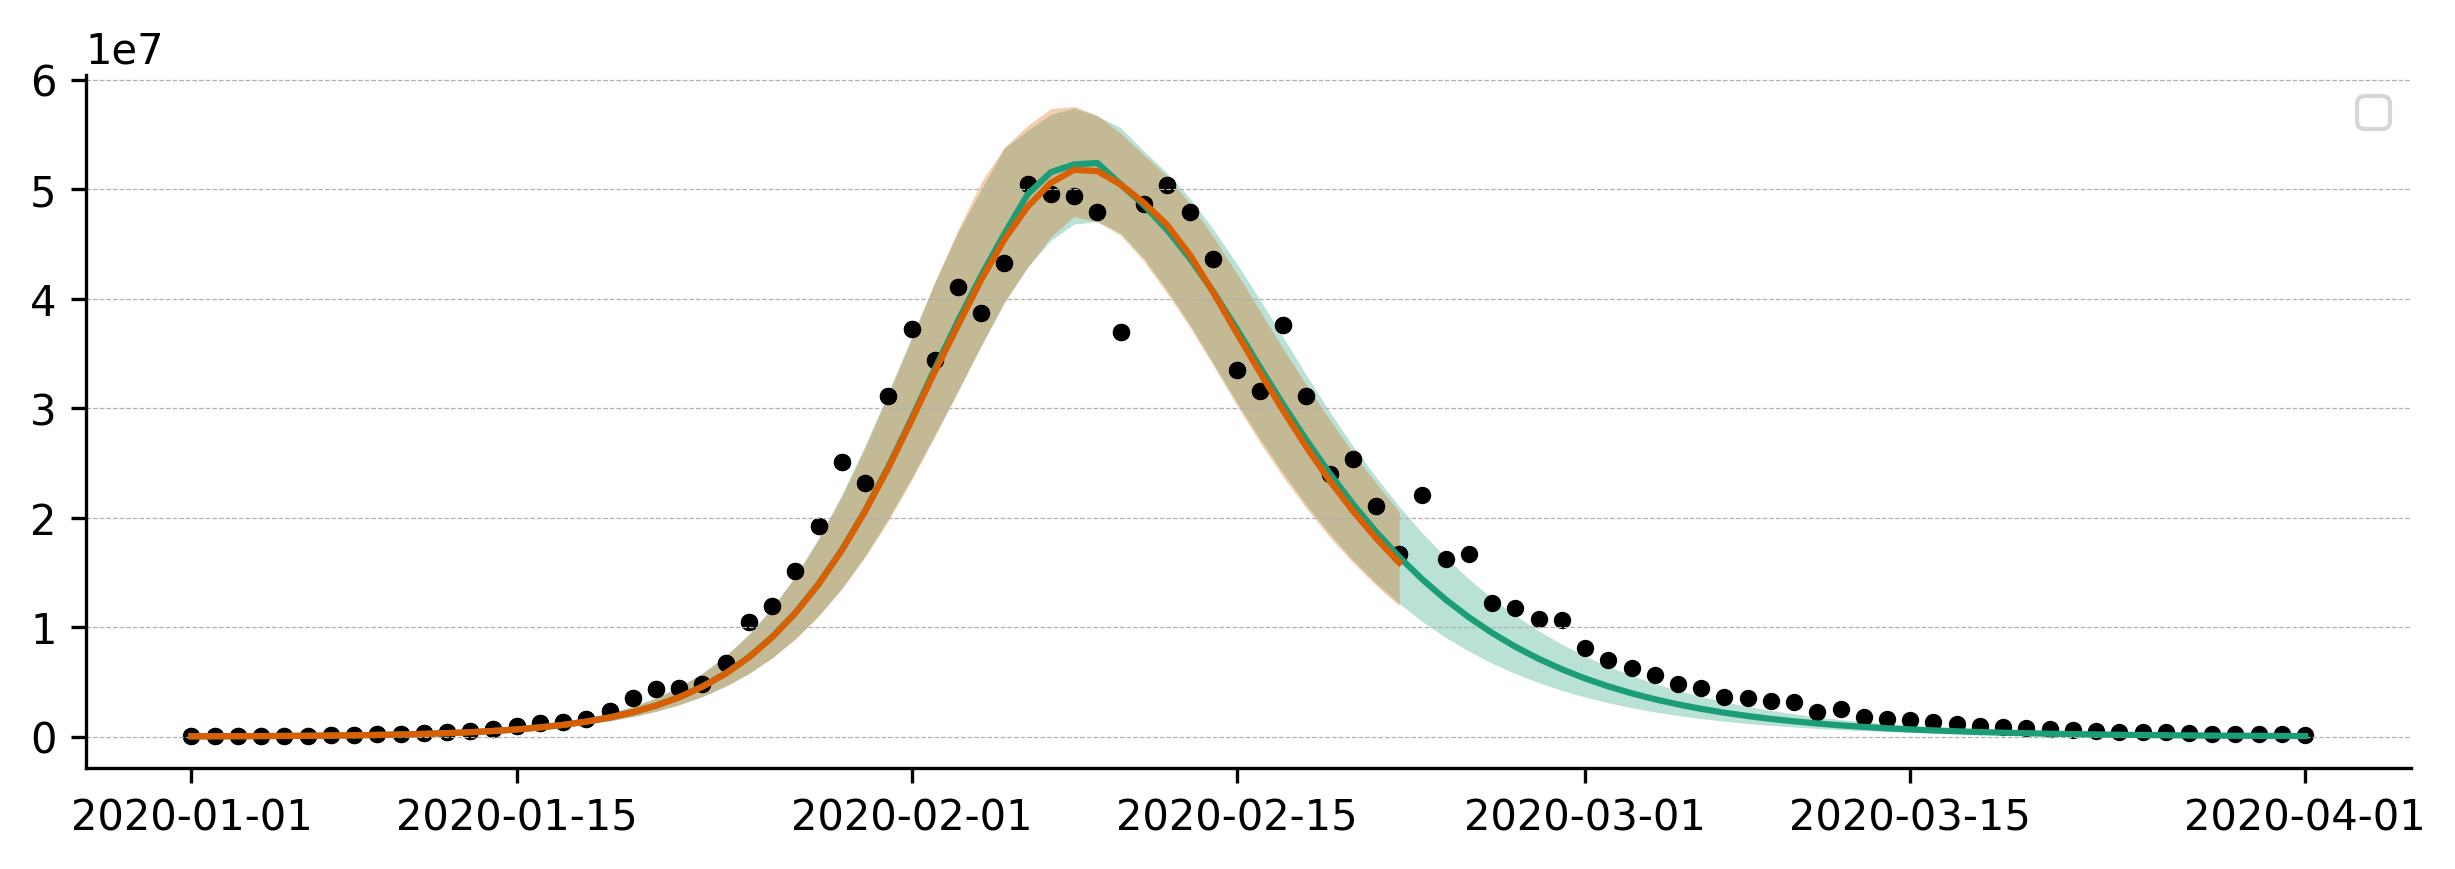

In [46]:
from epydemix.visualization import plot_selected_quantiles

# plot the projections
df_quantiles_calibration = compute_quantiles(results_abc_smc.get_selected_trajectories(), simulation_dates_calibration)
df_quantiles_projections = compute_quantiles(projections_trajectories, simulation_dates)

fig, ax = plt.subplots(dpi=300, figsize=(10, 3))
plot_selected_quantiles(df_quantiles_projections, data, ax=ax, colors=colors[0])
plot_selected_quantiles(df_quantiles_calibration, data.iloc[:-39], ax=ax, colors=colors[1])
ax.legend() 

## 3. Calibration of External Models